# Defining a Neural Network model in PyTorch and training it on the MNIST dataset

We will now develop a simple neural network in PyTorch to classify the MNIST dataset. We will use the simple feedforward neural network with a single hidden layer we described during the theory lectures.

We will use the `torch.nn` module to define the network and the `torch.optim` module to define the optimizer. We will also use the `torch.utils.data` module to load the MNIST dataset and the `torchvision` module to transform the images.

Let us start by describing these modules and then we will define the network and train it.

## torch.nn

The `torch.nn` module provides the basic building blocks for neural networks. It provides the `Module` class which is the base class for all neural network modules. We can define our own neural network by subclassing `Module` and defining the `forward` method.

For example, the following code defines a simple feedforward neural network with a single hidden layer:



In [ ]:
import torch
import torch.nn as nn

EPOCHS = 30
BATCH_SIZE = 10
NUM_HIDDEN = 128
LR = 0.1

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, NUM_HIDDEN)  # self.fc1(x) -> Wx + b -> a
        self.fc2 = nn.Linear(NUM_HIDDEN, 10)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  # z = sigma(a)
        x = torch.sigmoid(self.fc2(x))
        return x


It is important to note the roles played by the `__init__` and the `forward` methods. The `__init__` method is used to define the layers of the network, i.e., it is the place where the memory for those layers is allocated and the variables that point to it are defined. In this case, we have two fully connected layers. The first layer has 784 input features (the size of the MNIST images) and 128 output features. The second layer has 128 input features and 10 output features (the number of classes in the MNIST dataset).

The `forward` method is used to define the forward pass of the network. It takes the input tensor `x` and applies the layers defined in the `__init__` method to it. In this case, we apply the first fully connected layer and then the ReLU activation function. Finally, we apply the second fully connected layer. Note the idiom `x = torch.relu(self.fc1(x))` which applies the ReLU activation function to the output of the first fully connected layer and stores the result back in `x`. This is a common idiom in PyTorch.

`torch.nn` provides many other modules and activation functions that can be used to define more complex networks. The `Linear` module defines a linear transformation between two layers. We can describe it in terms of the notation we used in the theory lectures: the `__init__` method defines the matrix $\mathbf{W^l}$ and the vector $\mathbf{b^l}$; it's `forward` method takes as input $\mathbf{z}^{l-1}$ and computes the vector $\mathbf{a}^l = \mathbf{W^l} \mathbf{z}^{l-1} + \mathbf{b^l}$.

* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html

## torch.optim

The `torch.optim` module provides the optimizers used to train the neural networks. It provides many optimizers, such as SGD, Adam, RMSprop, etc. The following code defines an optimizer that uses the SGD (vanilla) algorithm:

* https://pytorch.org/docs/stable/optim.html



In [2]:
import torch.optim as optim   # Adam, RMSProp...

model = SimpleNN()
optimizer = optim.SGD(model.parameters(), lr=LR)



 The `parameters` method of the model returns an iterator over all the parameters of the model. The optimizer will update these parameters during training. To update the parameters, we need to call the `zero_grad` method of the optimizer to clear the gradients and then call the `step` method to update the parameters.



In [3]:
def train_step(model, optimizer, input, target, criterion):
    model.train()

    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    return loss


You should be able to recognize the pattern from previous PyTorch lectures.

- we first clear the gradients with `optimizer.zero_grad()` (ok, this is the first time we see this);
- we compute the output of the model and the loss: all these operations are tracked by PyTorch's autograd mechanism;
- so that we can then call `loss.backward()` to compute the gradients.

Finally, we call `optimizer.step()` to update the parameters. Note that we are **not** explicitlly passing the parameters to the optimizer, but they are updated because we passed them to the optimizer when we created it.

## torch.utils.data

The `torch.utils.data` module provides classes to load and manipulate datasets. The `Dataset` class is the base class for all datasets. We can define our own dataset by subclassing `Dataset` and defining the `__len__` and `__getitem__` methods. The `__len__` method should return the size of the dataset and the `__getitem__` method should return the $i$-th sample of the dataset.

The `DataLoader` class is used to load the dataset and provide batches of samples. It takes as input a dataset and the batch size. The following code shows how to load the MNIST dataset using the `DataLoader` class:



In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

def one_hot_encode(target):
    return F.one_hot(torch.tensor(target), num_classes=10).float()

transform = transforms.Compose([ # Concatenate a series of tensor's operations (in this case: toTensor and Normalize)
    transforms.ToTensor(),  # Convert into a tensor and implicitly normalize the data into [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # scales the values into [-1, 1]
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform, target_transform=one_hot_encode)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform, target_transform=one_hot_encode)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)



The `Compose` class is used to chain multiple transformations. In this case, we are using two transformations: `ToTensor` and `Normalize`. The `ToTensor` transformation converts the image to a tensor and scales the pixel values to the range $[0, 1]$. The `Normalize` transformation normalizes the tensor to have zero mean and unit variance.

The `MNIST` class is used to load the MNIST dataset. It takes as input the path where the dataset will be stored, whether it is the training or test set, and the transformations to apply to the images. Finally, the `DataLoader` class is used to load the dataset and provide batches of samples. It takes as input the dataset, the batch size, and whether to shuffle the samples.


Before training the network, let us define a utility function to compute the accuracy of the network on the test set. The following code shows how to do this:

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.view(-1, 784))
            _, predicted = torch.max(outputs.data, 1) # Returns a namedtuple (values, indices) where values is the 
                                                      # maximum value of each row of the input tensor in the given 
                                                      # dimension dim. And indices is the index location of each maximum 
                                                      # value found (argmax)
            _, labels = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # .item() cast from PyTorch tensor to integer
    return correct / total

Here three things are worth noting.

1. we are using the `torch.no_grad` context manager to disable gradient tracking. This is because we are only interested in computing the accuracy and not in computing the gradients.
2. we are `eval`-ing the model. This is because some layers, such as dropout and batch normalization, behave differently during training and evaluation. We want to evaluate the model in the same way we will use it in production. This is not strictly necessary for the simple network we are using here, but it is a good practice to get into.


We can now train the network using the MNIST dataset. The following code shows how to train the network using the MNIST dataset:

In [18]:
criterion = nn.MSELoss() # create an istance of nn.MSELoss
losses = []
accuracies = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 784) # view(images.shape[0], -1)
        # `view` is a PyTorch method that changes the shape of the tensor without changing the data
        # `-1` indicates that PyTorch should automatically calculate that size based on the total size of the tensor,
        # in this case, the first dim would be the BATCH_SIZE i.e. 10)
        # `784` is the number of elements for each image (for example, a 28×28 pixel image flattened into a vector)
        loss = train_step(model, optimizer, images, labels, criterion)

        if i % 100 == 0:
            losses.append(loss.item())

    print(f"Just completed epoch: {epoch}, current accuracy: {test(model, test_loader)}")
    accuracies.append(test(model, test_loader))

Just completed epoch: 0, current accuracy: 0.9493
Just completed epoch: 1, current accuracy: 0.9569
Just completed epoch: 2, current accuracy: 0.958
Just completed epoch: 3, current accuracy: 0.9619
Just completed epoch: 4, current accuracy: 0.9652
Just completed epoch: 5, current accuracy: 0.9681
Just completed epoch: 6, current accuracy: 0.9682
Just completed epoch: 7, current accuracy: 0.9652
Just completed epoch: 8, current accuracy: 0.9712
Just completed epoch: 9, current accuracy: 0.9712
Just completed epoch: 10, current accuracy: 0.9716
Just completed epoch: 11, current accuracy: 0.972
Just completed epoch: 12, current accuracy: 0.9722
Just completed epoch: 13, current accuracy: 0.9725
Just completed epoch: 14, current accuracy: 0.9753
Just completed epoch: 15, current accuracy: 0.9743
Just completed epoch: 16, current accuracy: 0.974
Just completed epoch: 17, current accuracy: 0.9733
Just completed epoch: 18, current accuracy: 0.9753
Just completed epoch: 19, current accuracy: 

In [20]:
# Saving the PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # Create a new directory inside the project's folder

# 2. Create model save path
MODEL_NAME = "01_NN_MNIST_model_v0.pth" # Python objects have .pth or .pt extension for PyTorch
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")

# 3. Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model saved")

Saving model to: models\01_NN_MNIST_model_v0.pth
Model saved


In [21]:
# To load in a saved state_dict() we have to instantiate a new instance of our model class
model_saved = SimpleNN()

# Load the saved state_dict of model_v0 (this will update the new instance with update parameters)
model_saved.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

## Results

Let us print the test accuracy of the network:

In [24]:
print(test(model_saved, test_loader))

0.9753


### Plots

We can also plot the loss and accuracy during training, and samples of the images and their predictions.

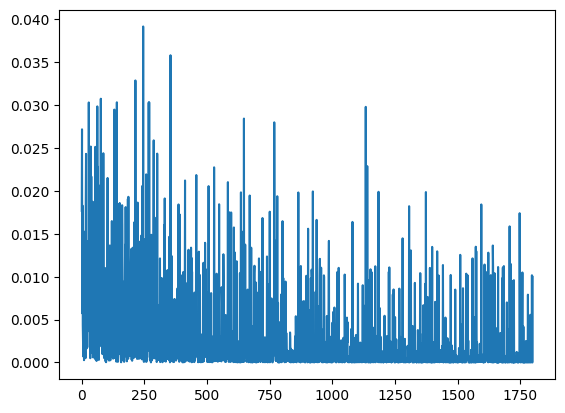

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses)

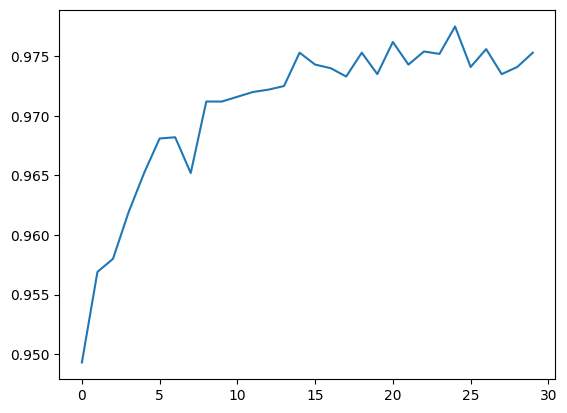

In [26]:
plt.plot(accuracies)

To plot images and their predictions, we start by collecting in three vectors the images, the true labels, and the predicted labels. We then plot a grid of images and their predictions. We use the `imshow` function to plot the images and

In [27]:
model.eval()
labels = []
predicted = []
images = []
with torch.no_grad():
    for data in test_loader:
        x,y = data

        y_ = model(x.view(-1, 784))
        y_ = y_.argmax(axis=1)
        y = y.argmax(axis=1)

        labels += y.tolist()
        predicted += y_.tolist()
        images += x



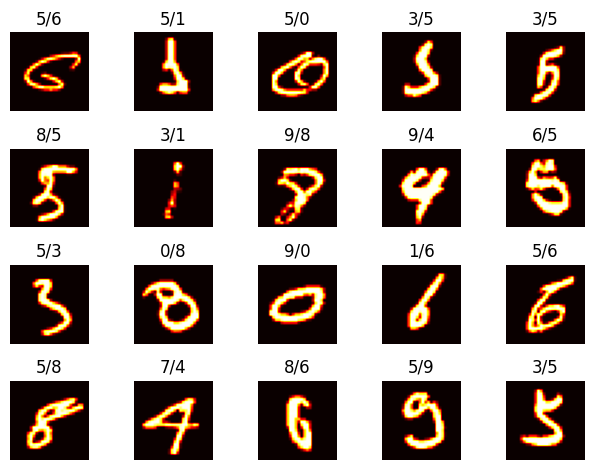

In [28]:

def plot_images(images, predicted, labels):
    fig, axs = plt.subplots(4, 5)
    for i in range(20):
        ax = axs[i // 5, i % 5]

        if predicted[i] == labels[i]:
            ax.imshow(images[i].view(28, 28).numpy(), cmap='gray')
        else:
            ax.imshow(images[i].view(28, 28).numpy(), cmap='hot')

        ax.set_title(f"{predicted[i]}/{labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

error_indices = [i for i in range(len(labels)) if labels[i] != predicted[i]]
imgs = [images[i] for i in error_indices]
preds = [predicted[i] for i in error_indices]
labs = [labels[i] for i in error_indices]

plot_images(imgs, preds, labs)